## Import Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

## Load Dataset

In [3]:
# load the Excel workbook and first sheet into a DataFrame
file_path = "../data/raw/ELECTRICITY_SOLD_TO_ULTIMATE_CONSUMERS.xls"
xlsx = pd.ExcelFile(file_path)
print("Available sheets:", xlsx.sheet_names)

Available sheets: ['Sales to customers - All India', 'Sales to customers - statewise']


In [4]:
# Load Excel file
df_year = pd.read_excel(xlsx, sheet_name=0)
df_state = pd.read_excel(xlsx, sheet_name=1)

## Clean Column Names

In [5]:
def clean_columns(df):
    df.columns = (
        df.columns
        .str.strip()
        .str.lower()
        .str.replace("&", "and")
        .str.replace(" ", "_")
    )
    return df

df_year = clean_columns(df_year)
df_state = clean_columns(df_state)


## Handle Missing Values

In [6]:
# Replace blanks / symbols like "-" or "(A)"

df_year.replace(["-", "(A)", "(NA)"], np.nan, inplace=True)
df_state.replace(["-", "(A)", "(NA)"], np.nan, inplace=True)

In [7]:
# Convert numeric columns

df_year.iloc[:, 1:] = df_year.iloc[:, 1:].apply(pd.to_numeric, errors="coerce")
df_state.iloc[:, 1:] = df_state.iloc[:, 1:].apply(pd.to_numeric, errors="coerce")

In [8]:
# Fill missing values (time-series logic)

df_year.ffill(inplace=True)
df_state.fillna(0, inplace=True)

In [9]:
# Check for missing values
df_year.isnull().sum()

year                                           0
total_sold_to_ultimate__consumers              0
domestic                                       0
commercial                                     0
industrial__power_at_low_and_medium_voltage    0
industrial__power_at_high__voltage             0
public_lighting                                0
traction                                       0
agriculture                                    0
public_water_works_and_sewage_pumping          0
miscellaneous                                  0
dtype: int64

In [10]:
df_state.isnull().sum()

state/_union_territory                         0
total_sold_to_ultimate__consumers              0
domestic                                       0
commercial                                     0
industrial__power_at_low_and_medium_voltage    0
industrial__power_at_high__voltage             0
public_lighting                                0
traction                                       0
agriculture                                    0
public_water_works_and_sewage_pumping          0
miscellaneous                                  0
dtype: int64

In [24]:
# Save cleaned data as CSV (ensure target directory exists)

out_path = Path("/workspaces/Electricity_consumption_churn_analysis/data/export/electricity_consumption_2000_2008_statewise.csv")
out_path.parent.mkdir(parents=True, exist_ok=True)

df_state.to_csv(out_path, index=False)

print("Cleaned dataset saved successfully!")


Cleaned dataset saved successfully!


## Year-wise Electricity Trend

Available columns: ['year', 'total_sold_to_ultimate__consumers', 'domestic', 'commercial', 'industrial__power_at_low_and_medium_voltage', 'industrial__power_at_high__voltage', 'public_lighting', 'traction', 'agriculture', 'public_water_works_and_sewage_pumping', 'miscellaneous']
Using column: total_sold_to_ultimate__consumers


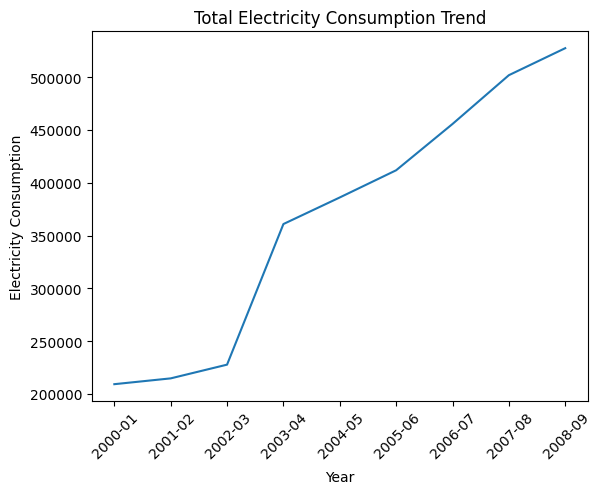

In [12]:
col_name = 'total_sold_to_ultimate_consumers'
if col_name not in df_year.columns:
    print('Available columns:', df_year.columns.tolist())
    candidates = [c for c in df_year.columns if any(k in c for k in ['total','sold','ultimate','consum'])]
    if candidates:
        col_name = candidates[0]
        print(f'Using column: {col_name}')
    else:
        raise KeyError(col_name)

plt.figure()
plt.plot(df_year['year'], df_year[col_name])
plt.title('Total Electricity Consumption Trend')
plt.xlabel('Year')
plt.ylabel('Electricity Consumption')
plt.xticks(rotation=45)
plt.show()

In [13]:
# Create Sector Aggregations

df_state["industrial_total"] = (
    df_state["industrial__power_at_low_and_medium_voltage"] +
    df_state["industrial__power_at_high__voltage"]
)

In [14]:
# Sector Share Calculation

df_state["domestic_share"] = df_state["domestic"] / df_state["total_sold_to_ultimate__consumers"]
df_state["commercial_share"] = df_state["commercial"] / df_state["total_sold_to_ultimate__consumers"]
df_state["industrial_share"] = df_state["industrial_total"] / df_state["total_sold_to_ultimate__consumers"]
df_state["agriculture_share"] = df_state["agriculture"] / df_state["total_sold_to_ultimate__consumers"]

## Define Churn Risk

In [15]:
def churn_risk(row):
    if row["industrial_share"] > 0.45:
        return "High"
    elif row["industrial_share"] > 0.30:
        return "Medium"
    else:
        return "Low"

df_state["churn_risk"] = df_state.apply(churn_risk, axis=1)

## Identify High-Risk States

In [16]:
high_risk_states = df_state[df_state["churn_risk"] == "High"].sort_values(
    "industrial_share", ascending=False
)

In [17]:
high_risk_states[
    ["state/_union_territory", "industrial_share", "total_sold_to_ultimate__consumers"]
].head(10)

,state/_union_territory,industrial_share,total_sold_to_ultimate__consumers
30,D. & N.Haveli,0.929603,3070.00
31,Daman & Diu,0.924850,1325.35
10,Jharkhand,0.754758,12582.52
34,Puducherry,0.686769,1864.98
8,Himachal Pradesh,0.623859,5460.51
5,Goa,0.619347,2616.98
19,Orissa,0.567091,11732.52
16,Meghalaya,0.559006,945.50
25,Uttara Khand,0.483023,4736.11
4,Chhattisgarh,0.466332,12021.45


## Visualization

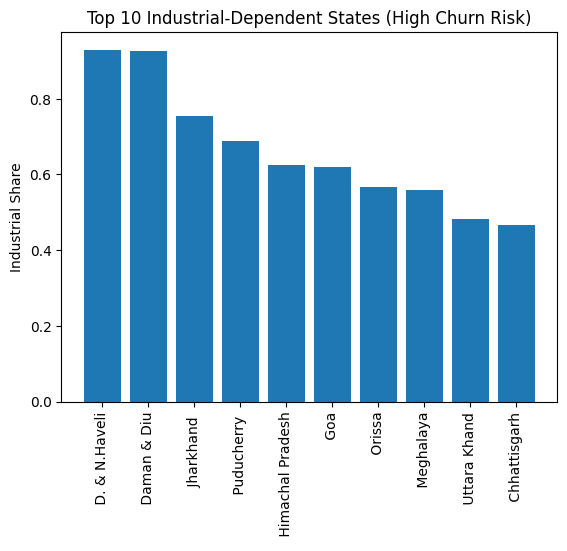

In [18]:
plt.figure()
plt.bar(
    high_risk_states["state/_union_territory"].head(10),
    high_risk_states["industrial_share"].head(10)
)
plt.xticks(rotation=90)
plt.title("Top 10 Industrial-Dependent States (High Churn Risk)")
plt.ylabel("Industrial Share")
plt.show()


## Domestic Stability Check

In [19]:
print(df_state.columns)


Index(['state/_union_territory', 'total_sold_to_ultimate__consumers',
       'domestic', 'commercial', 'industrial__power_at_low_and_medium_voltage',
       'industrial__power_at_high__voltage', 'public_lighting', 'traction',
       'agriculture', 'public_water_works_and_sewage_pumping', 'miscellaneous',
       'industrial_total', 'domestic_share', 'commercial_share',
       'industrial_share', 'agriculture_share', 'churn_risk'],
      dtype='object')


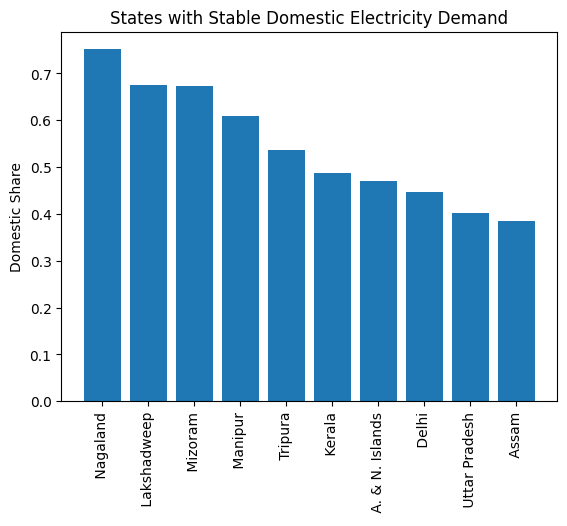

In [20]:
stable_states = df_state.sort_values("domestic_share", ascending=False).head(10)

plt.figure()
plt.bar(
    stable_states["state/_union_territory"],
    stable_states["domestic_share"]
)
plt.xticks(rotation=90)
plt.title("States with Stable Domestic Electricity Demand")
plt.ylabel("Domestic Share")
plt.show()

In [21]:
df_state.columns.tolist()

['state/_union_territory',
 'total_sold_to_ultimate__consumers',
 'domestic',
 'commercial',
 'industrial__power_at_low_and_medium_voltage',
 'industrial__power_at_high__voltage',
 'public_lighting',
 'traction',
 'agriculture',
 'public_water_works_and_sewage_pumping',
 'miscellaneous',
 'industrial_total',
 'domestic_share',
 'commercial_share',
 'industrial_share',
 'agriculture_share',
 'churn_risk']

In [25]:
df_state.to_csv("../data/statewise_electricity_clean.csv", index=False)